In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Sat Jan 27 11:26:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-6_ze2zq/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

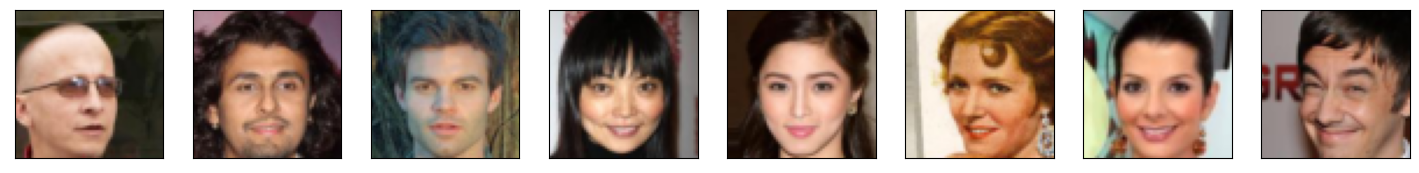

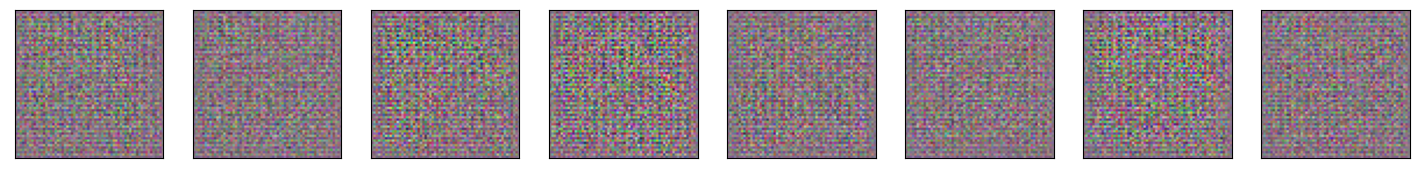

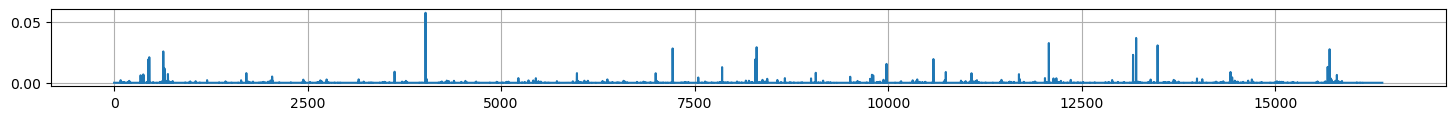

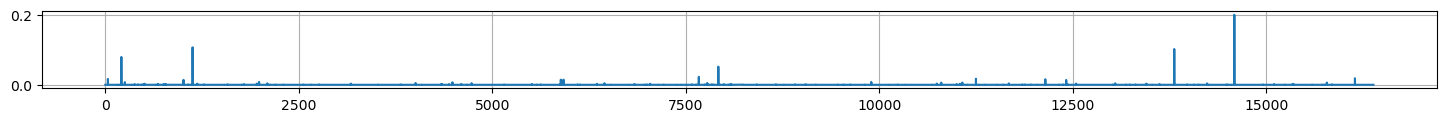

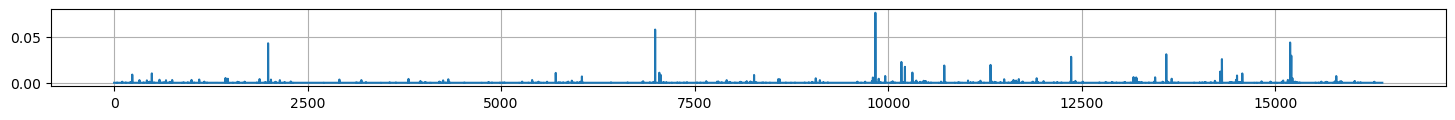

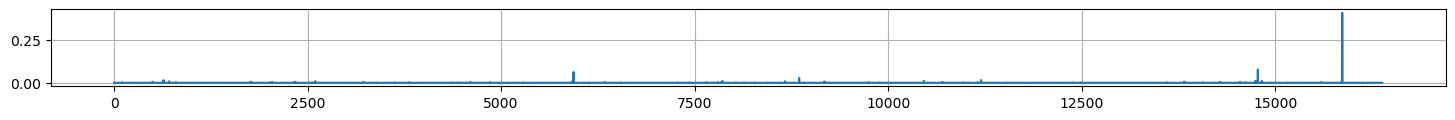

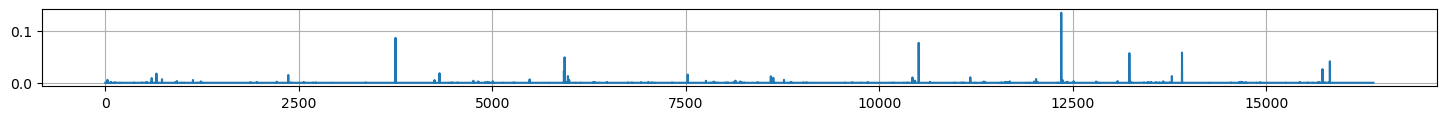

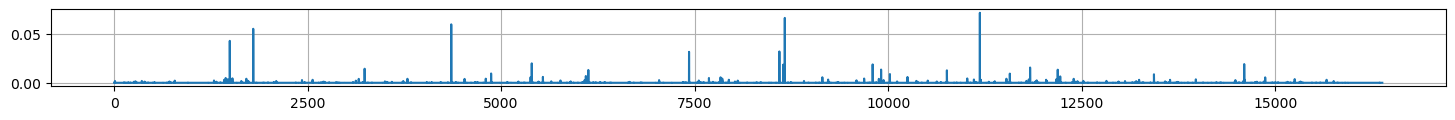

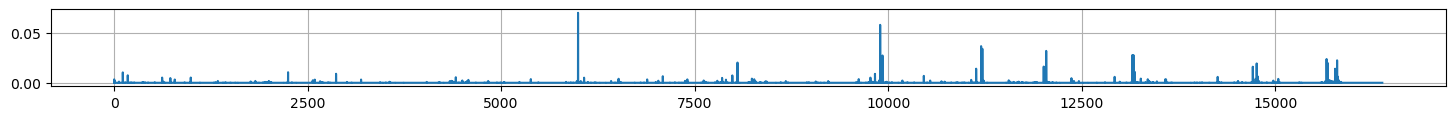

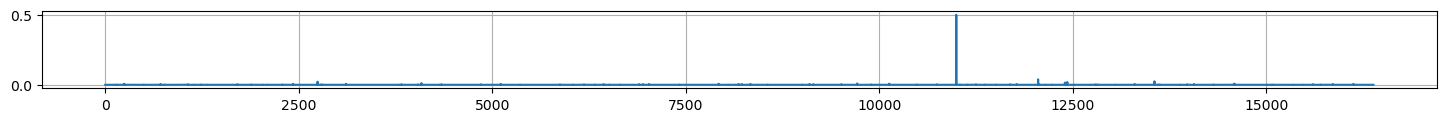

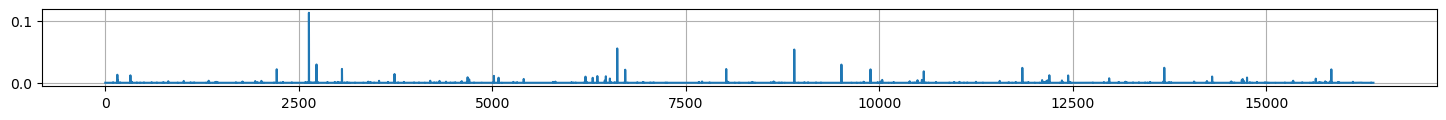

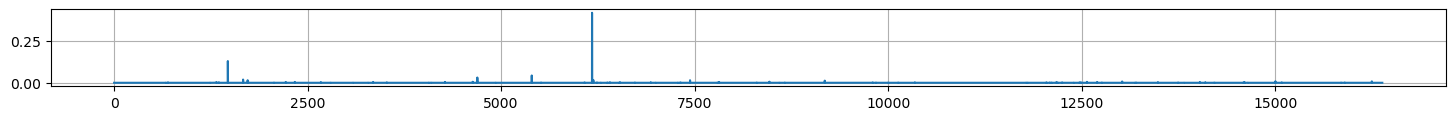

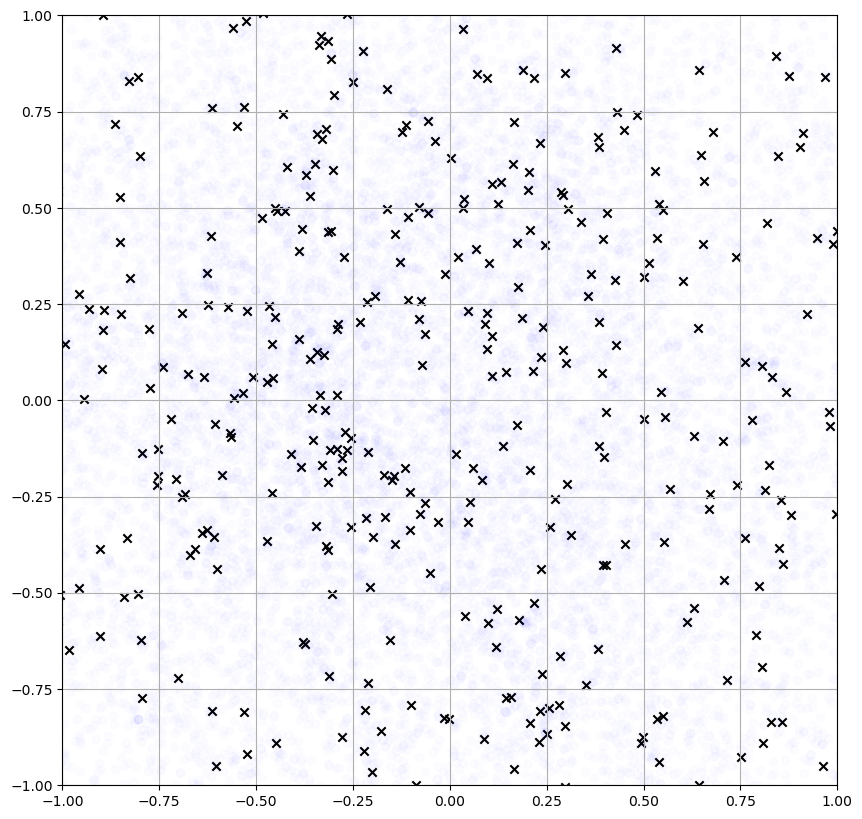

1
lse_loss -7.454787254333496
commit_loss 0.639830470085144
recon_loss 0.10227590799331665
2
lse_loss -7.5090131759643555
commit_loss 0.6313797235488892
recon_loss 0.10161840915679932
3
lse_loss -7.869841575622559
commit_loss 0.6149927377700806
recon_loss 0.09504137933254242
4
lse_loss -7.8109846115112305
commit_loss 0.6084886789321899
recon_loss 0.0946137011051178
5
lse_loss -7.9470624923706055
commit_loss 0.5943776965141296
recon_loss 0.08903442323207855
6
lse_loss -8.003891944885254
commit_loss 0.5809082984924316
recon_loss 0.0884280726313591
7
lse_loss -8.164645195007324
commit_loss 0.5613438487052917
recon_loss 0.08510678261518478
8
lse_loss -8.263052940368652
commit_loss 0.5439555048942566
recon_loss 0.08236803859472275
9
lse_loss -8.213799476623535
commit_loss 0.5359119176864624
recon_loss 0.08013248443603516
10
lse_loss -8.198168754577637
commit_loss 0.5261706709861755
recon_loss 0.07664915174245834
11
lse_loss -8.453391075134277
commit_loss 0.5111683011054993
recon_loss 0.0742

91
lse_loss -8.640738487243652
commit_loss 0.386443555355072
recon_loss 0.024921154603362083
92
lse_loss -8.818352699279785
commit_loss 0.3928651213645935
recon_loss 0.02428605407476425
93
lse_loss -8.569357872009277
commit_loss 0.3900434076786041
recon_loss 0.027997057884931564
94
lse_loss -8.6867094039917
commit_loss 0.39273229241371155
recon_loss 0.024360930547118187
95
lse_loss -8.63503360748291
commit_loss 0.3880648612976074
recon_loss 0.024490319192409515
96
lse_loss -8.592305183410645
commit_loss 0.39039790630340576
recon_loss 0.02499321475625038
97
lse_loss -8.670294761657715
commit_loss 0.39252227544784546
recon_loss 0.024090921506285667
98
lse_loss -8.6876802444458
commit_loss 0.3890293836593628
recon_loss 0.026122070848941803
99
lse_loss -8.512625694274902
commit_loss 0.38908061385154724
recon_loss 0.024998769164085388
100
lse_loss -8.724814414978027
commit_loss 0.3898855745792389
recon_loss 0.022954454645514488
101
lse_loss -8.60965633392334
commit_loss 0.38894122838974
rec

178
lse_loss -8.655882835388184
commit_loss 0.3686310052871704
recon_loss 0.013610104098916054
179
lse_loss -8.455323219299316
commit_loss 0.3712138235569
recon_loss 0.013700870797038078
180
lse_loss -8.625386238098145
commit_loss 0.3688279390335083
recon_loss 0.01447699498385191
181
lse_loss -8.65988826751709
commit_loss 0.36796027421951294
recon_loss 0.013419726863503456
182
lse_loss -8.584486961364746
commit_loss 0.37032651901245117
recon_loss 0.011948492377996445
183
lse_loss -8.626276969909668
commit_loss 0.36654072999954224
recon_loss 0.013380289077758789
184
lse_loss -8.673949241638184
commit_loss 0.3691087067127228
recon_loss 0.013444406911730766
185
lse_loss -8.567961692810059
commit_loss 0.36407485604286194
recon_loss 0.012689055874943733
186
lse_loss -8.688990592956543
commit_loss 0.36795926094055176
recon_loss 0.012751132249832153
187
lse_loss -8.57681941986084
commit_loss 0.36435365676879883
recon_loss 0.014278355054557323
188
lse_loss -8.460089683532715
commit_loss 0.3648

265
lse_loss -8.5690279006958
commit_loss 0.3534866273403168
recon_loss 0.00970478355884552
266
lse_loss -8.578097343444824
commit_loss 0.3534817099571228
recon_loss 0.009088320657610893
267
lse_loss -8.569674491882324
commit_loss 0.35842061042785645
recon_loss 0.009077068418264389
268
lse_loss -8.413886070251465
commit_loss 0.35488179326057434
recon_loss 0.008691548369824886
269
lse_loss -8.728161811828613
commit_loss 0.35453563928604126
recon_loss 0.008985333144664764
270
lse_loss -8.54372501373291
commit_loss 0.3555665612220764
recon_loss 0.008707160130143166
271
lse_loss -8.74527645111084
commit_loss 0.3527575433254242
recon_loss 0.00838689599186182
272
lse_loss -8.576766014099121
commit_loss 0.35218244791030884
recon_loss 0.008653420954942703
273
lse_loss -8.66096019744873
commit_loss 0.3546217381954193
recon_loss 0.007903704419732094
274
lse_loss -8.735098838806152
commit_loss 0.35232114791870117
recon_loss 0.008498724550008774
275
lse_loss -8.624415397644043
commit_loss 0.352089

352
lse_loss -8.838435173034668
commit_loss 0.348982572555542
recon_loss 0.007051715161651373
353
lse_loss -8.735365867614746
commit_loss 0.34713423252105713
recon_loss 0.007314423099160194
354
lse_loss -8.626837730407715
commit_loss 0.3501017093658447
recon_loss 0.007352287881076336
355
lse_loss -8.678366661071777
commit_loss 0.34838593006134033
recon_loss 0.007441370747983456
356
lse_loss -8.664103507995605
commit_loss 0.3481029272079468
recon_loss 0.008405469357967377
357
lse_loss -8.676009178161621
commit_loss 0.3498287796974182
recon_loss 0.007272827439010143
358
lse_loss -8.717297554016113
commit_loss 0.3491247892379761
recon_loss 0.0074853613041341305
359
lse_loss -8.697545051574707
commit_loss 0.34667232632637024
recon_loss 0.007770293392241001
360
lse_loss -8.624064445495605
commit_loss 0.3506440222263336
recon_loss 0.007332950830459595
361
lse_loss -8.71515941619873
commit_loss 0.34880852699279785
recon_loss 0.006700692232698202
362
lse_loss -8.707526206970215
commit_loss 0.3

lse_loss -8.803690910339355
commit_loss 0.3431909680366516
recon_loss 0.0064657144248485565
439
lse_loss -8.79273509979248
commit_loss 0.3457886874675751
recon_loss 0.006375763565301895
440
lse_loss -9.044936180114746
commit_loss 0.3411612808704376
recon_loss 0.0062727490440011024
441
lse_loss -8.840336799621582
commit_loss 0.34608495235443115
recon_loss 0.006120042875409126
442
lse_loss -8.949236869812012
commit_loss 0.344081312417984
recon_loss 0.0067458972334861755
443
lse_loss -8.874650001525879
commit_loss 0.34433451294898987
recon_loss 0.006275517866015434
444
lse_loss -8.7871732711792
commit_loss 0.3467625379562378
recon_loss 0.006876067724078894
445
lse_loss -8.921660423278809
commit_loss 0.3444966673851013
recon_loss 0.0061384886503219604
446
lse_loss -8.934905052185059
commit_loss 0.34104105830192566
recon_loss 0.005896301940083504
447
lse_loss -8.9229097366333
commit_loss 0.3421599864959717
recon_loss 0.006351008545607328
448
lse_loss -8.863045692443848
commit_loss 0.3444114

526
lse_loss -8.86524486541748
commit_loss 0.3402542471885681
recon_loss 0.00592193566262722
527
lse_loss -8.97264575958252
commit_loss 0.34051209688186646
recon_loss 0.005635659210383892
528
lse_loss -9.003933906555176
commit_loss 0.34050846099853516
recon_loss 0.006014486309140921
529
lse_loss -8.942011833190918
commit_loss 0.3386448919773102
recon_loss 0.005454670172184706
530
lse_loss -8.965846061706543
commit_loss 0.34406885504722595
recon_loss 0.0061006671749055386
531
lse_loss -8.846320152282715
commit_loss 0.3406980037689209
recon_loss 0.006036918610334396
532
lse_loss -8.928252220153809
commit_loss 0.340946227312088
recon_loss 0.006219588220119476
533
lse_loss -8.939806938171387
commit_loss 0.3410484790802002
recon_loss 0.005815242417156696
534
lse_loss -8.971329689025879
commit_loss 0.3412433862686157
recon_loss 0.006113320589065552
535
lse_loss -8.921881675720215
commit_loss 0.3414759337902069
recon_loss 0.005597795359790325
536
lse_loss -8.947527885437012
commit_loss 0.3419

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp='rand')

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-6
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 